# Trabajo Practico 1

Estudiantes:

- Alonso Araya Calvo
- Pedro Soto
- Sofia Oviedo

# Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.spatial.distance import jensenshannon

# Cargando dataset

In [5]:
#tomado de https://www.kaggle.com/code/wailinnoo/intrusion-detection-system-using-kdd99-dataset
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz',
                    origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
pd_data_frame = pd.read_csv(path, header=None)

# The CSV file has no column heads, so add them
pd_data_frame.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please 

/Users/aaraya/.keras/datasets/kddcup.data_10_percent.gz


# Limpieza del dataset y generacion de subset del dataset

In [6]:
# For now, just drop NA's (rows with missing values), in case there are
pd_data_frame.dropna(inplace=True, axis=1)

# Checking for DUPLICATE values
pd_data_frame.drop_duplicates(keep='first', inplace=True)

In [7]:
# Filter the DataFrame to keep only 'normal.' and 'back.' outcomes
filtered_df = pd_data_frame[pd_data_frame['outcome'].isin(['normal.', 'back.'])].copy()

In [8]:
list_nominal_features = ["flag", "protocol_type", "service"]

# Apply one-hot encoding to the nominal features
df_encoded = pd.get_dummies(filtered_df, columns=list_nominal_features)

# Convert boolean columns (from one-hot encoding) to integers (0 or 1) in df_encoded
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

In [9]:
df_attacks = df_encoded[df_encoded['outcome'] == 'back.'].copy()
df_no_attacks = df_encoded[df_encoded['outcome'] == 'normal.'].copy()

# Parte 1 Análisis Descriptivo

## 1a Analisis de momentos estadisticos

- Media
- Desviacion estandar
- Inclinacion
- Kurtosis

In [10]:
df_attacks_without_outcome = df_attacks.drop('outcome', axis=1)
df_normal_without_outcome = df_no_attacks.drop('outcome', axis=1)

attack_without_outcomes_column_names = df_attacks_without_outcome.columns
attack_tensor = torch.tensor(df_attacks_without_outcome.values, dtype=torch.float32)

normal_without_outcomes_column_names = df_normal_without_outcome.columns
no_attack_tensor = torch.tensor(df_normal_without_outcome.values, dtype=torch.float32)

In [11]:
def calculate_moments(dataset_tensor, feature_names):
    means = torch.mean(dataset_tensor, dim=0)
    stds = torch.std(dataset_tensor, dim=0)

    z = (dataset_tensor - means) / stds
    z = torch.where(torch.isfinite(z), z, torch.zeros_like(z))

    skews = torch.mean(z ** 3, dim=0)
    kurtosis = torch.mean(z ** 4, dim=0) - 3

    stats_df = pd.DataFrame({
        "Media": means.numpy(),
        "Desviación Estándar": stds.numpy(),
        "Inclinación": skews.numpy(),
        "Kurtosis": kurtosis.numpy()
    }, index=feature_names)

    display(stats_df)

### Momentos Estadisticos para Datos de Ataque

In [12]:
calculate_moments(attack_tensor, attack_without_outcomes_column_names)

,Media,Desviación Estándar,Inclinación,Kurtosis
duration,0.293388,1.660627,6.201858,39.309826
src_bytes,53666.890625,4722.463867,-6.375224,42.617058
dst_bytes,8129.908203,919.138550,-5.915854,35.871834
land,0.000000,0.000000,0.000000,-3.000000
wrong_fragment,0.000000,0.000000,0.000000,-3.000000
...,...,...,...,...
service_tftp_u,0.000000,0.000000,0.000000,-3.000000
service_tim_i,0.000000,0.000000,0.000000,-3.000000
service_time,0.000000,0.000000,0.000000,-3.000000
service_urh_i,0.000000,0.000000,0.000000,-3.000000


In [13]:
stats_df = pd.DataFrame(index=df_attacks_without_outcome.columns)
stats_df["Mean"] = df_attacks_without_outcome.mean()
stats_df["Std"] = df_attacks_without_outcome.std()
stats_df["Skewness"] = df_attacks_without_outcome.skew()
stats_df["Kurtosis"] = df_attacks_without_outcome.kurt()

display(stats_df)

,Mean,Std,Skewness,Kurtosis
duration,0.293388,1.660627,6.221125,39.607862
src_bytes,53666.892562,4722.463858,-6.395032,42.939136
dst_bytes,8129.908058,919.138524,-5.934233,36.144889
land,0.000000,0.000000,0.000000,0.000000
wrong_fragment,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
service_tftp_u,0.000000,0.000000,0.000000,0.000000
service_tim_i,0.000000,0.000000,0.000000,0.000000
service_time,0.000000,0.000000,0.000000,0.000000
service_urh_i,0.000000,0.000000,0.000000,0.000000


### Momentos Estadisticos para Paquetes Normales

In [14]:
calculate_moments(no_attack_tensor, normal_without_outcomes_column_names)

,Media,Desviación Estándar,Inclinación,Kurtosis
duration,188.932388,1320.953003,10.840396,164.942474
src_bytes,1270.249146,36017.765625,59.171650,3578.733887
dst_bytes,3720.620850,39526.839844,70.640572,6578.883301
land,0.000011,0.003374,296.354523,87825.000000
wrong_fragment,0.000000,0.000000,0.000000,-3.000000
...,...,...,...,...
service_tftp_u,0.000011,0.003374,296.354523,87825.000000
service_tim_i,0.000023,0.004772,209.550690,43909.996094
service_time,0.000398,0.019958,50.063965,2504.428955
service_urh_i,0.000159,0.012624,79.186501,6268.572266


In [15]:
stats_df = pd.DataFrame(index=df_normal_without_outcome.columns)
stats_df["Mean"] = df_normal_without_outcome.mean()
stats_df["Std"] = df_normal_without_outcome.std()
stats_df["Skewness"] = df_normal_without_outcome.skew()
stats_df["Kurtosis"] = df_normal_without_outcome.kurt()

display(stats_df)

,Mean,Std,Skewness,Kurtosis
duration,188.932394,1320.952947,10.840767,164.955803
src_bytes,1270.249226,36017.765413,59.173673,3579.019616
dst_bytes,3720.620423,39526.841178,70.642967,6579.405283
land,0.000011,0.003374,296.364640,87832.000000
wrong_fragment,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
service_tftp_u,0.000011,0.003374,296.364640,87832.000000
service_tim_i,0.000023,0.004772,209.557868,43913.499909
service_time,0.000398,0.019958,50.065674,2504.628760
service_urh_i,0.000159,0.012624,79.189195,6269.071386


## 1b Histogramas y Distancia Jensen Shannon

### Histogramas para datos de ataque backdoor

In [16]:
def generate_feature_histogram_and_calculate_jensen_shannon(df_normal, df_backdoor, feature_names, bins=30):
    js_distances = []

    for feat in feature_names:
        normal_df_values = df_normal[feat].values
        backdoor_df_values = df_backdoor[feat].values

        limits_histogram = (min(normal_df_values.min(), backdoor_df_values.min()),
                            max(normal_df_values.max(), backdoor_df_values.max()))

        hist_normal, _ = np.histogram(normal_df_values, bins=bins, range=limits_histogram)
        hist_backdoor, _ = np.histogram(backdoor_df_values, bins=bins, range=limits_histogram)

        hist_normal = hist_normal / hist_normal.sum()
        hist_backdoor = hist_backdoor / hist_backdoor.sum()

        jsd = jensenshannon(hist_normal, hist_backdoor)
        js_distances.append(jsd)

        plt.figure(figsize=(6, 4))
        plt.hist(normal_df_values, bins=bins, range=limits_histogram, alpha=0.5, label="Normal", color='blue',
                 density=True)
        plt.hist(backdoor_df_values, bins=bins, range=limits_histogram, alpha=0.5, label="Backdoor", color='red',
                 density=True)
        plt.title(f"Histograma de {feat} (Distancia JS: {jsd:.4f})")
        plt.xlabel("Valor")
        plt.ylabel("Densidad")
        plt.legend()
        plt.show()

    js_df = pd.DataFrame({
        "Feature": feature_names,
        "DistanciaJS": js_distances
    }).sort_values(by="DistanciaJS", ascending=False)

    display(js_df)

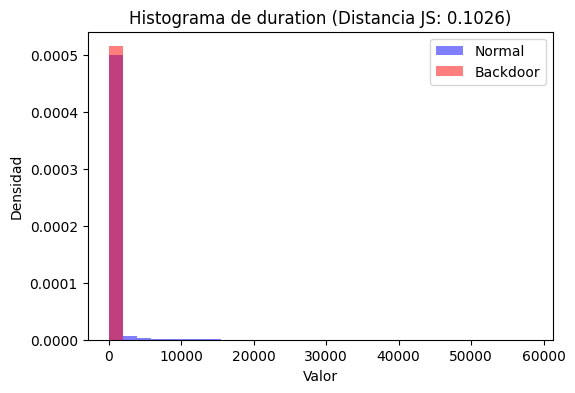

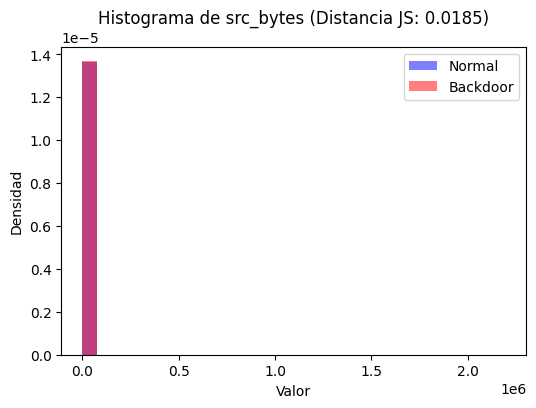

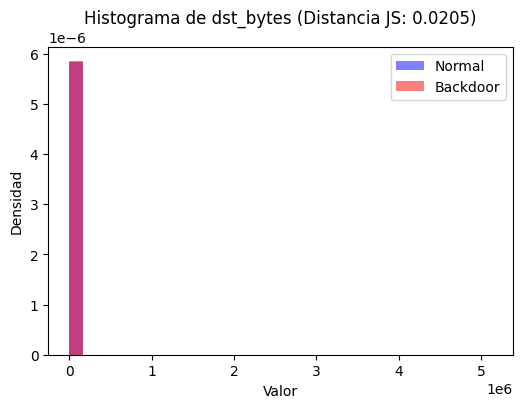

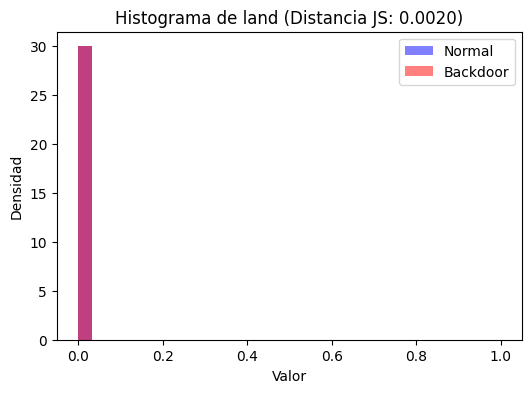

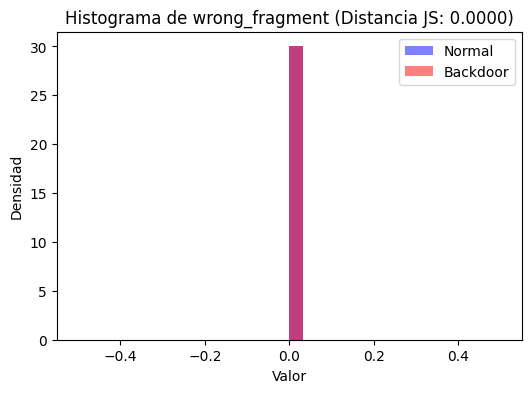

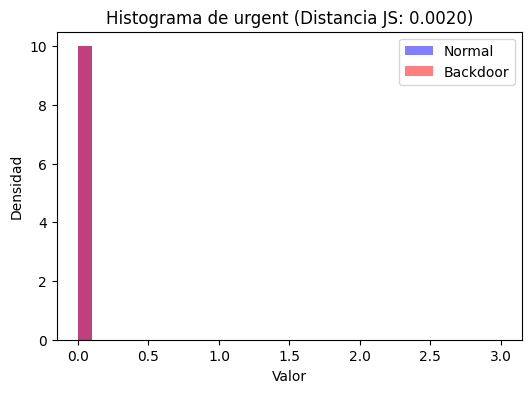

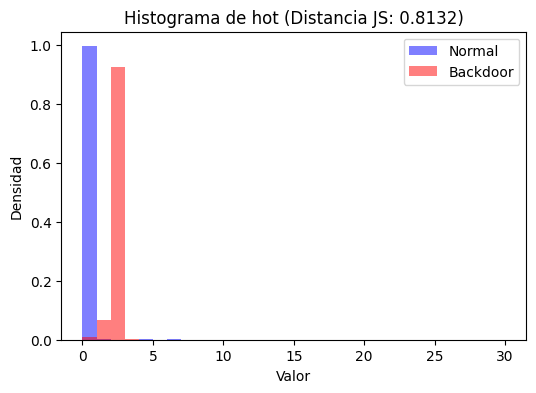

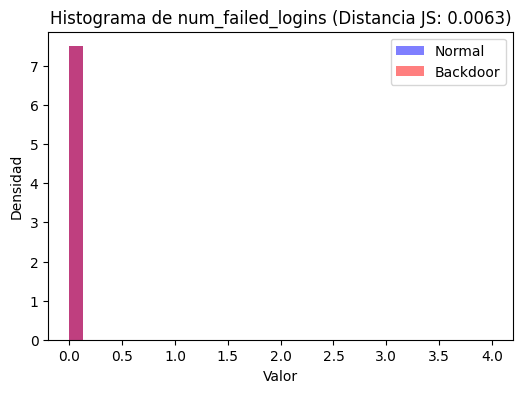

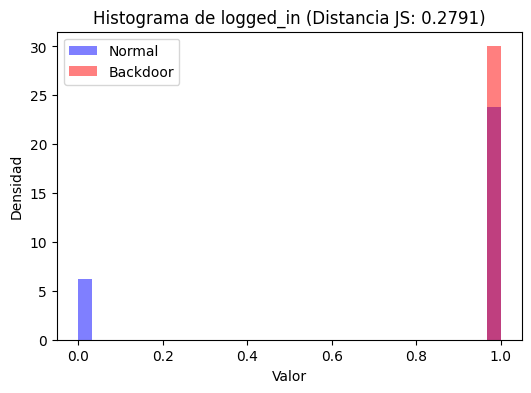

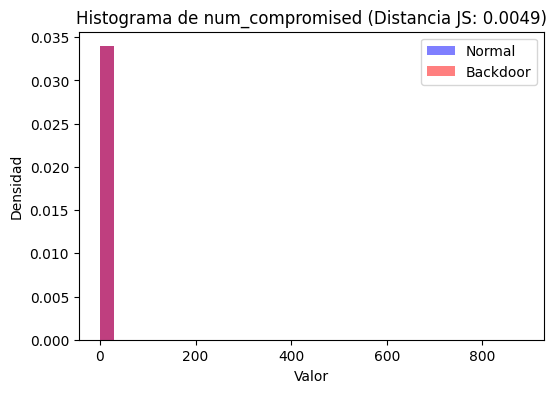

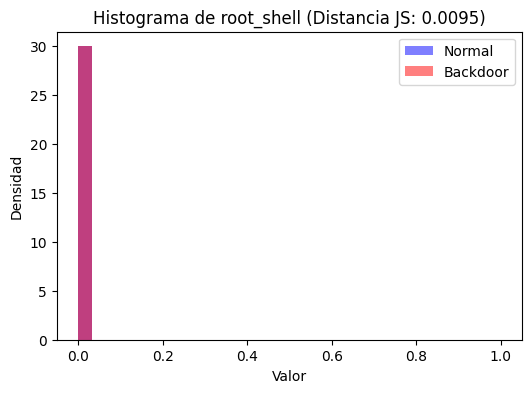

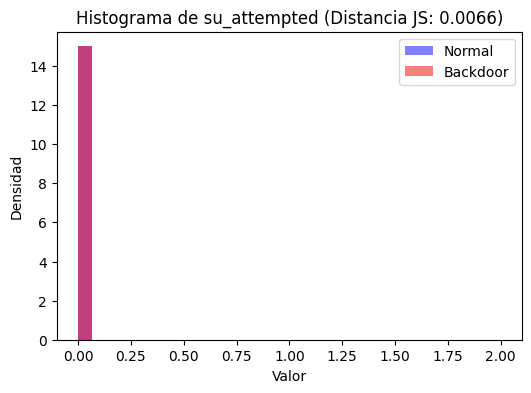

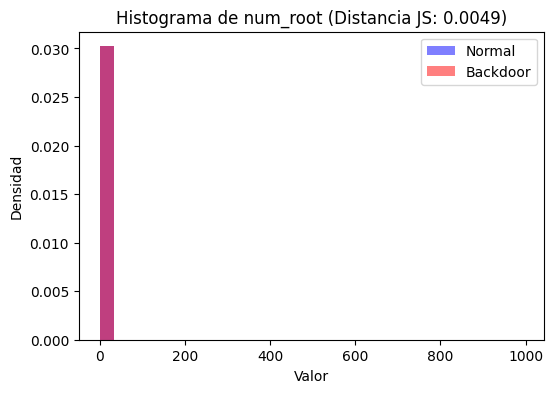

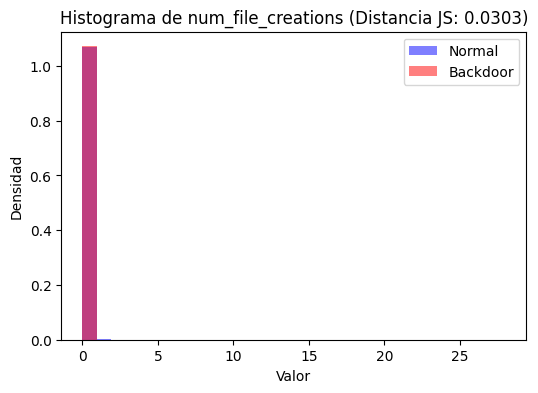

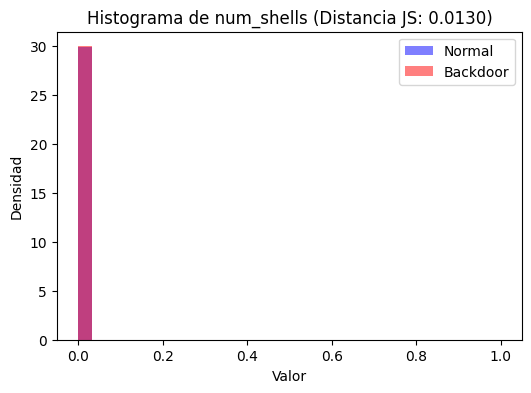

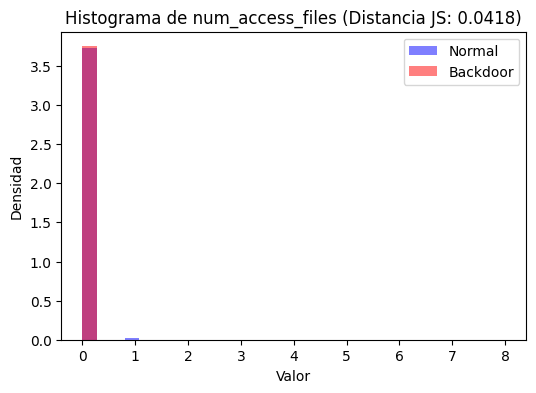

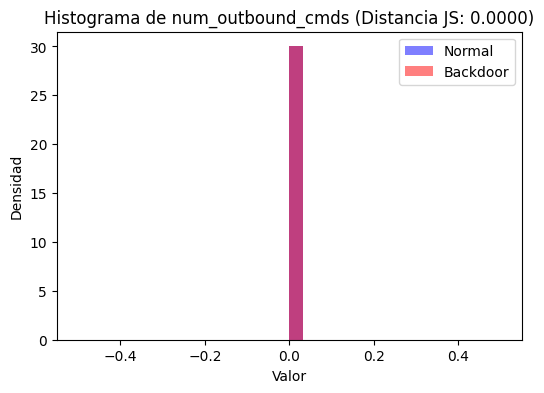

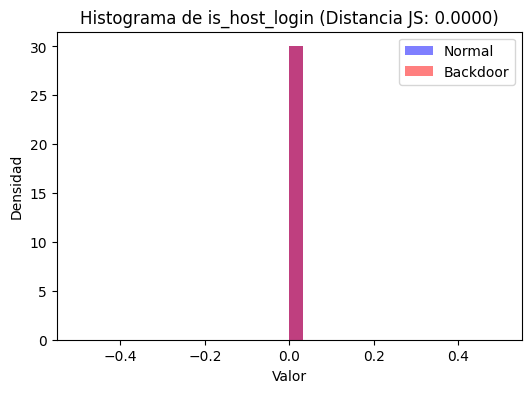

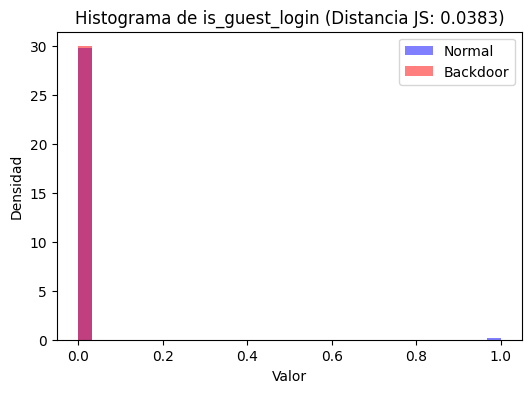

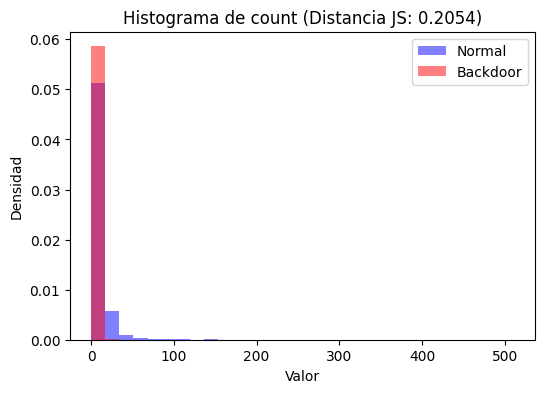

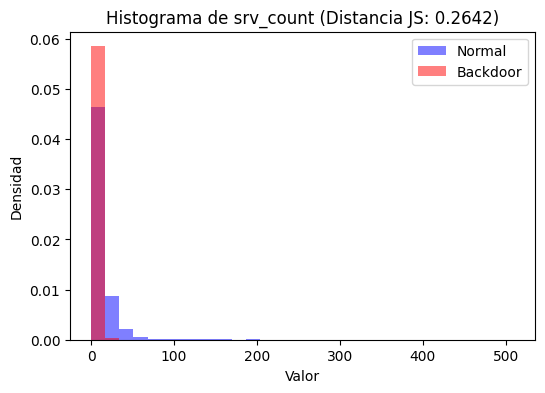

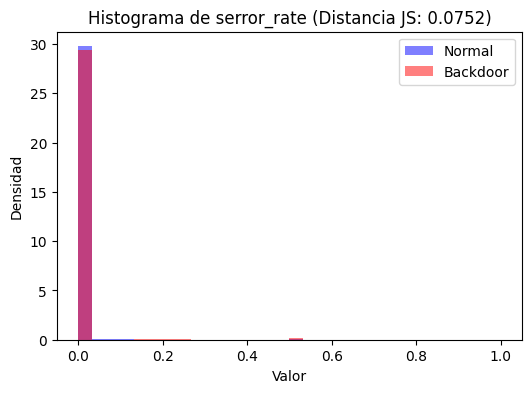

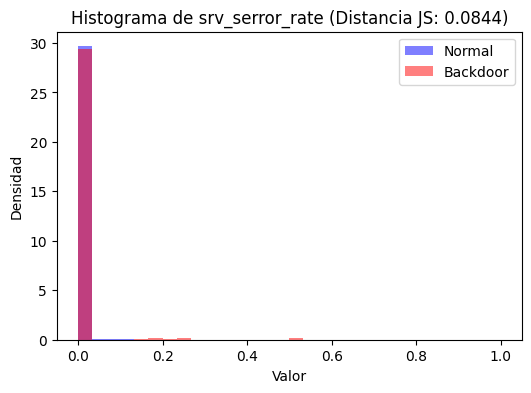

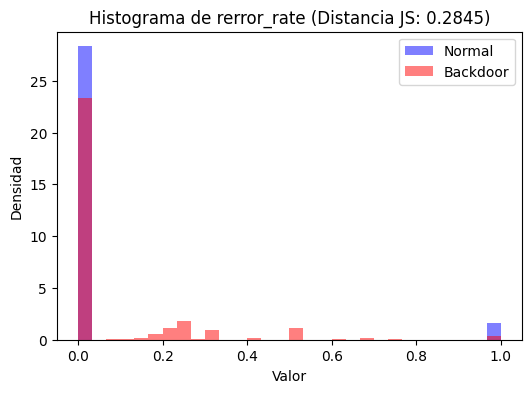

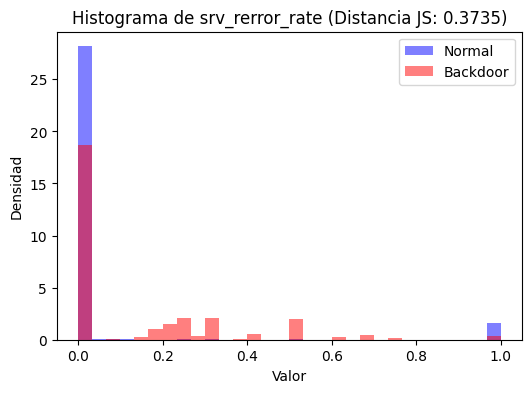

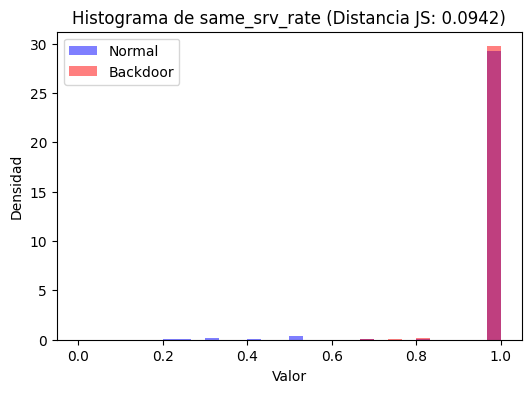

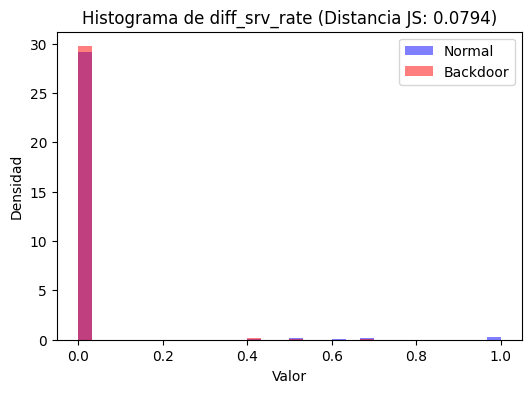

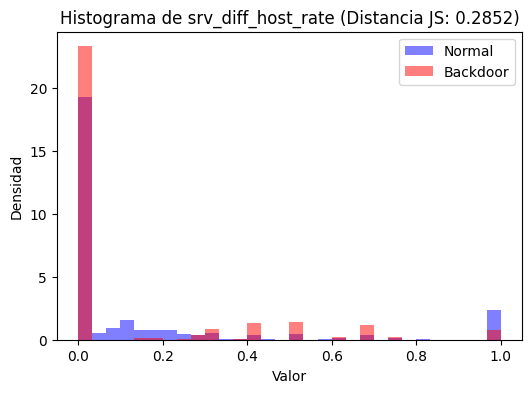

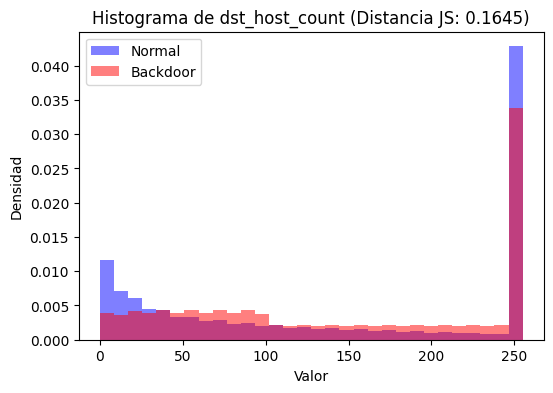

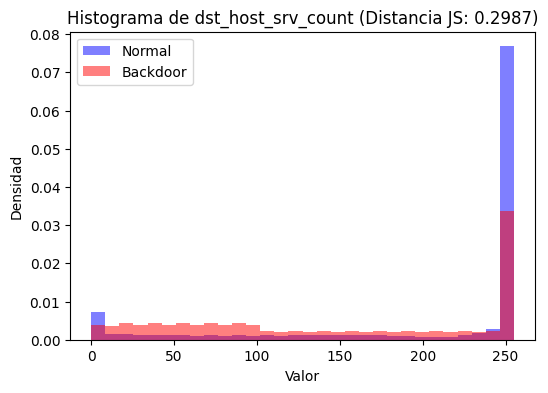

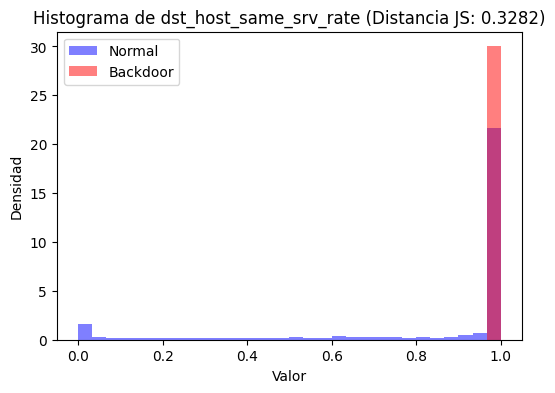

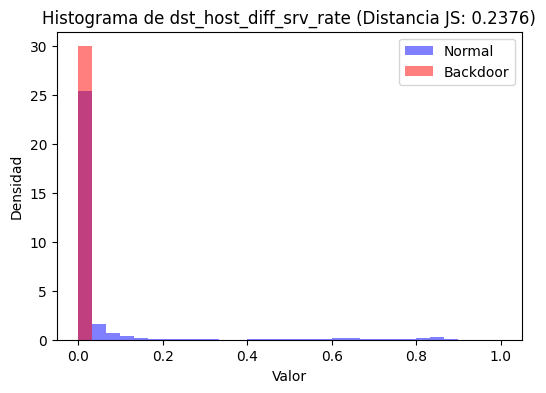

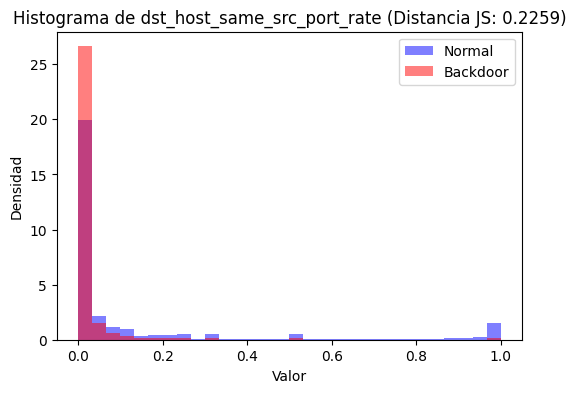

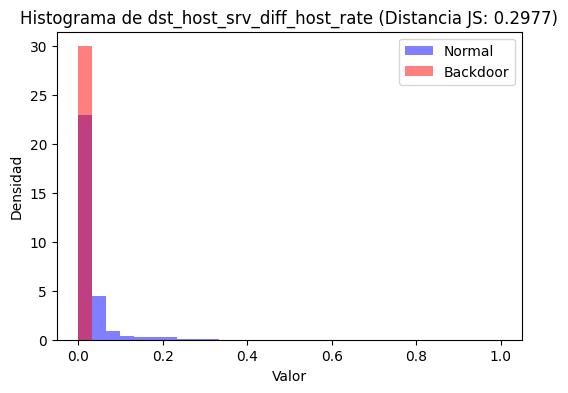

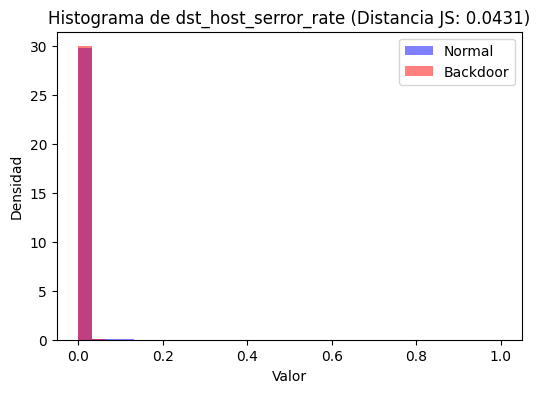

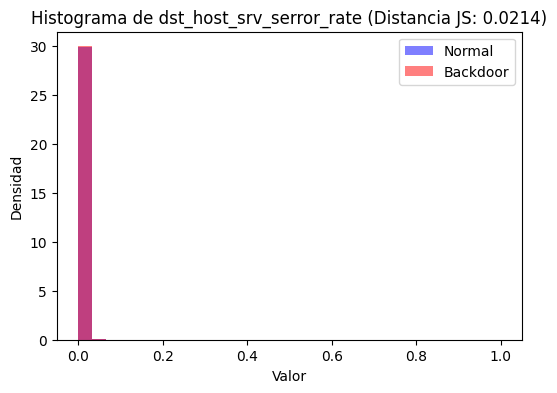

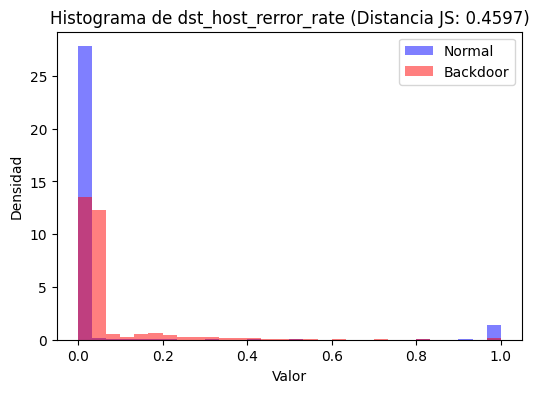

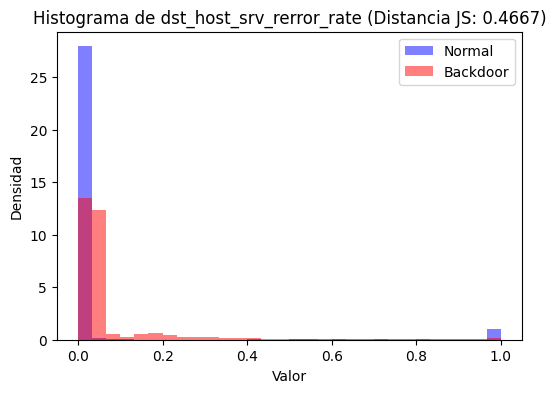

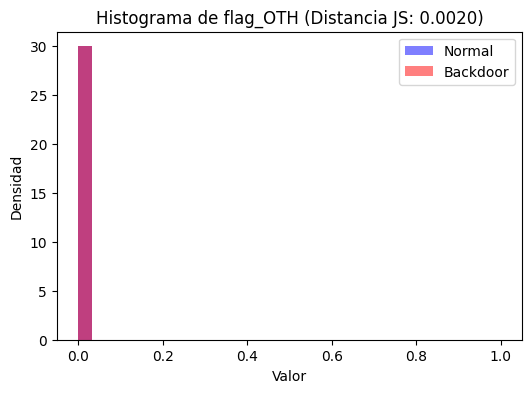

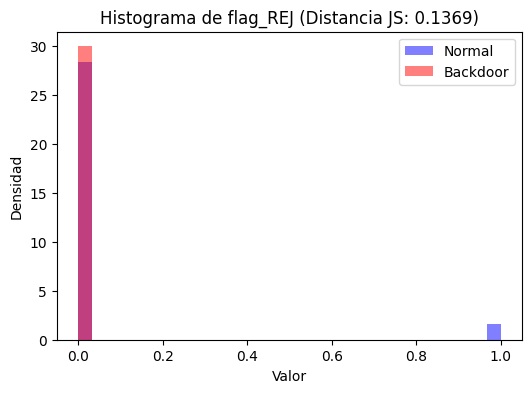

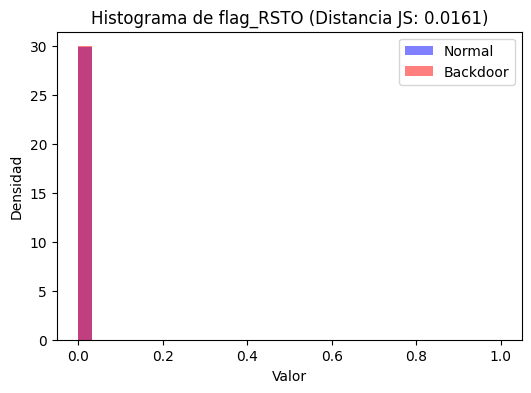

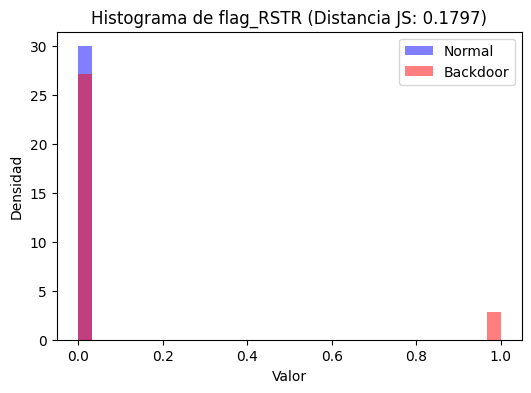

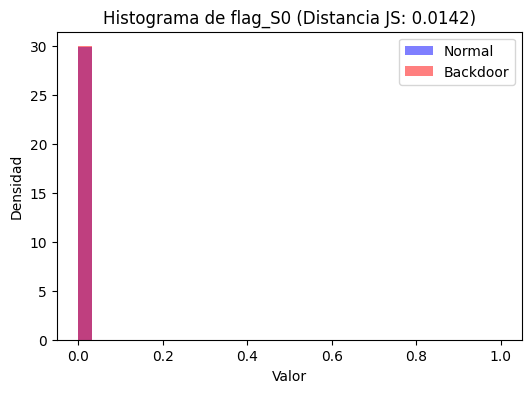

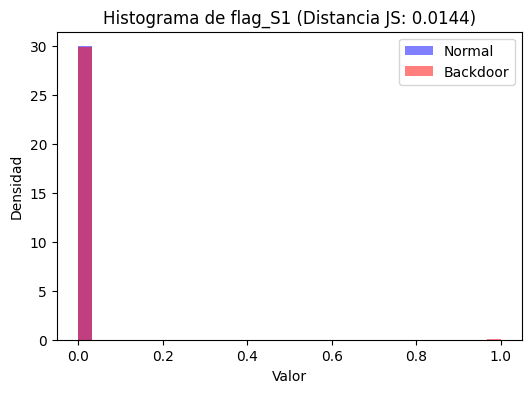

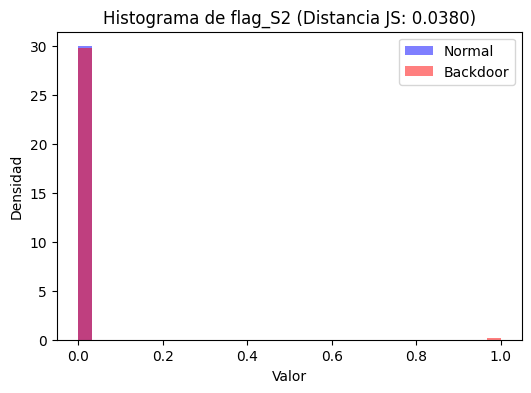

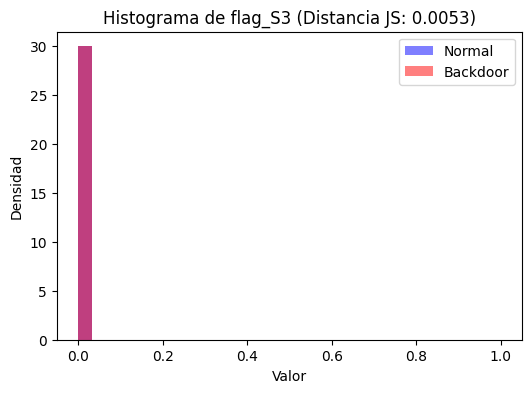

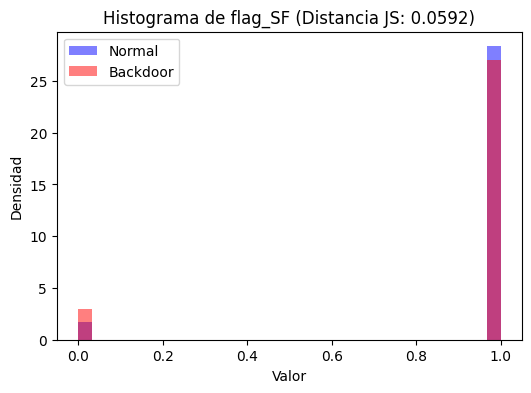

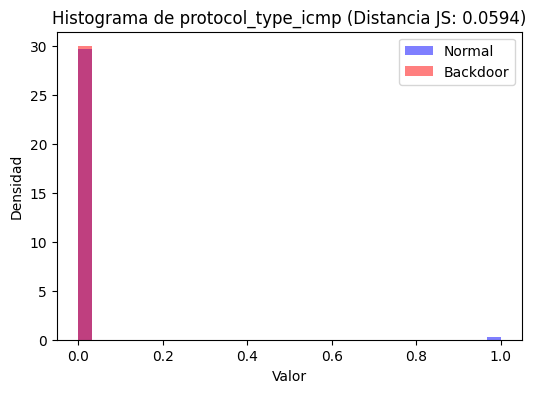

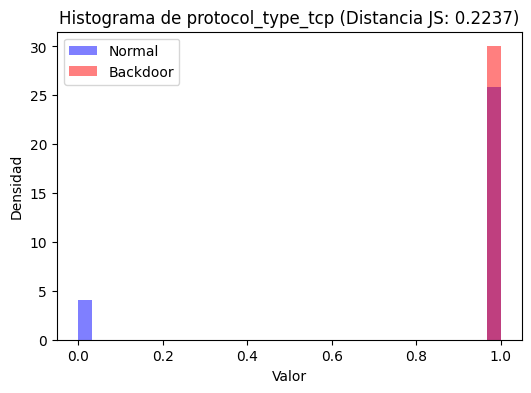

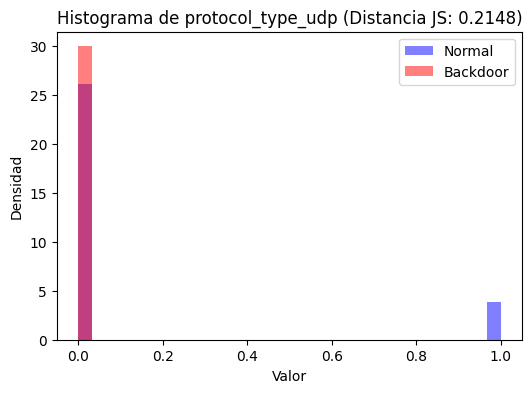

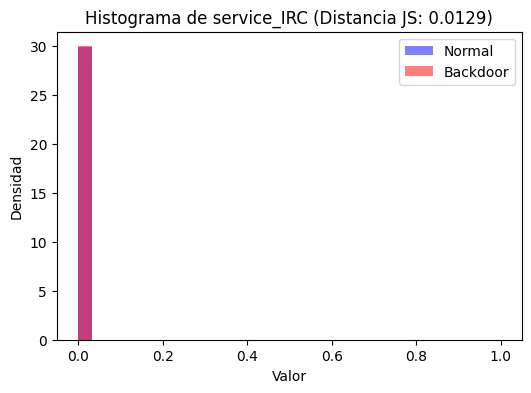

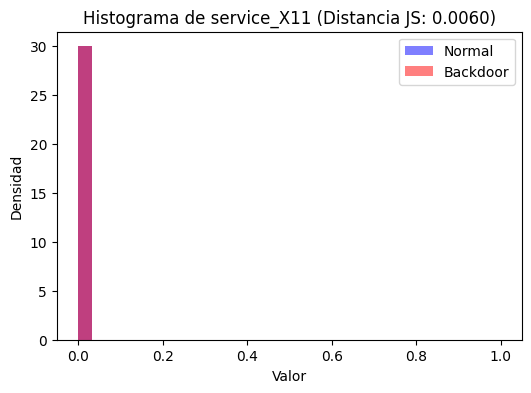

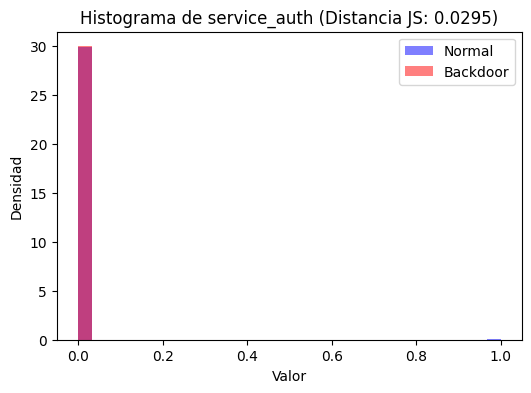

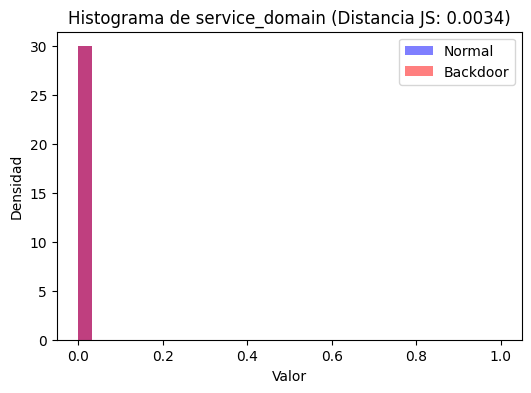

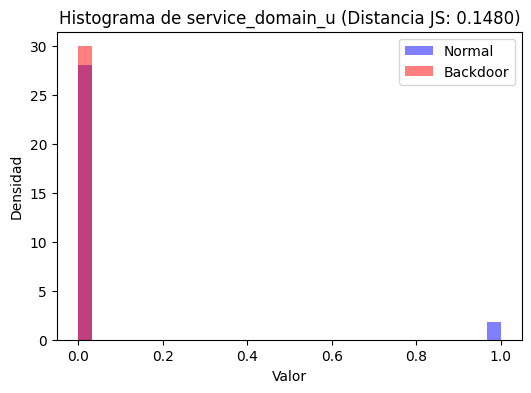

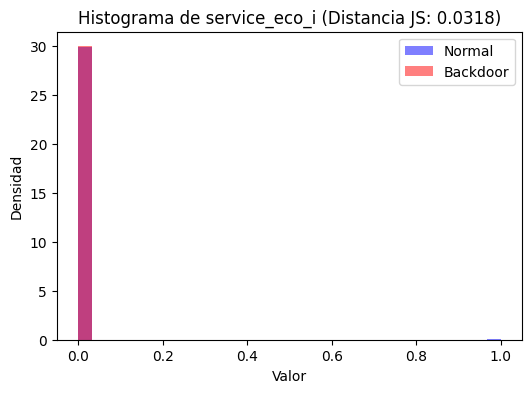

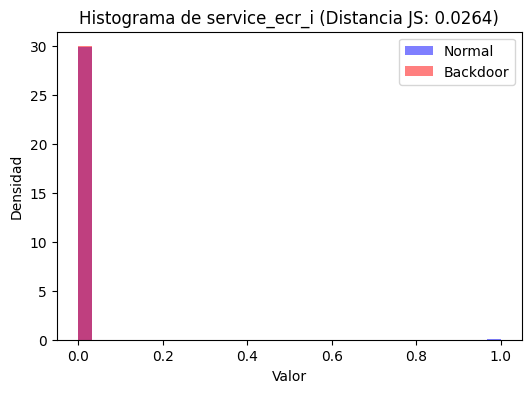

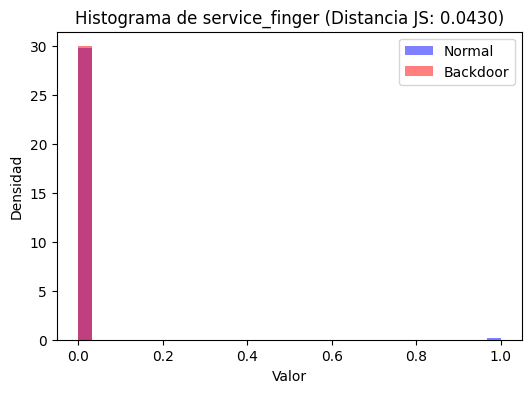

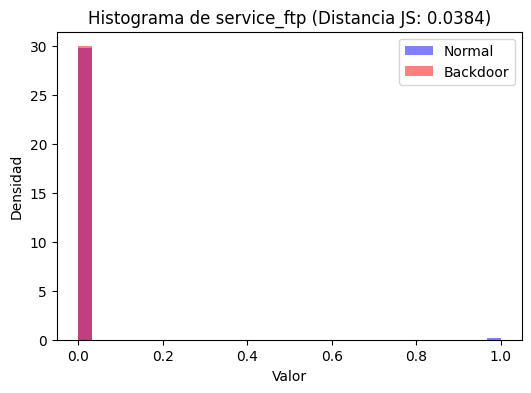

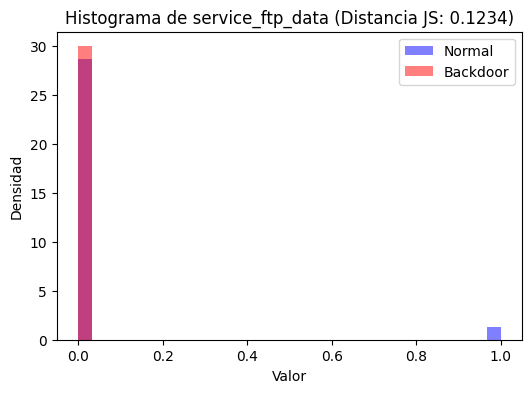

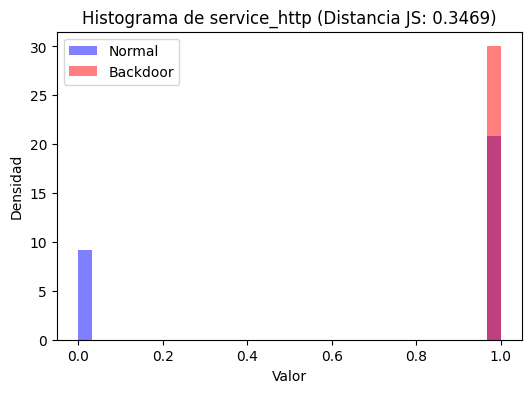

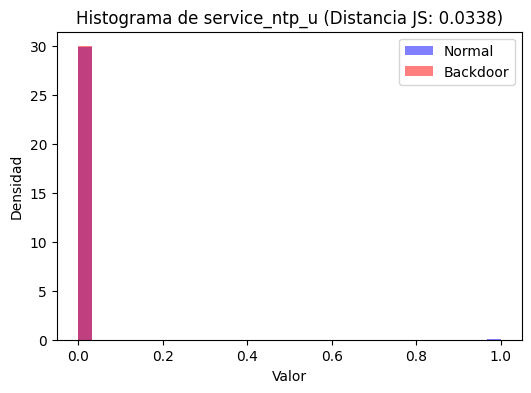

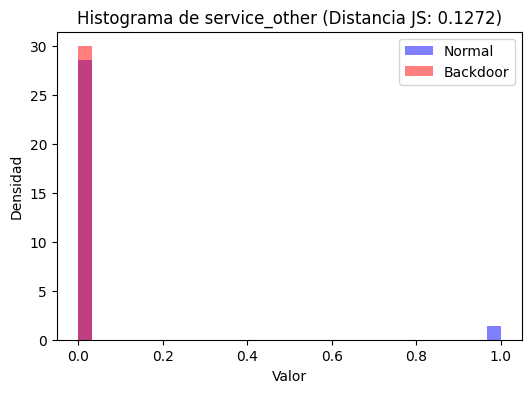

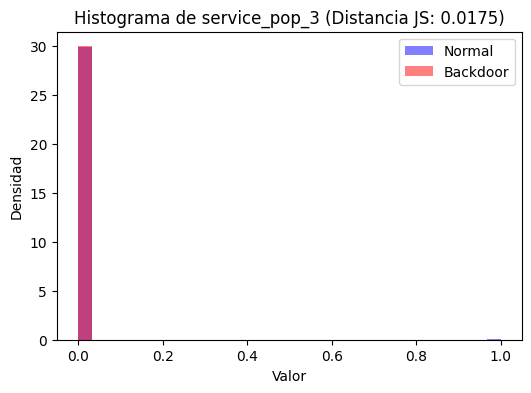

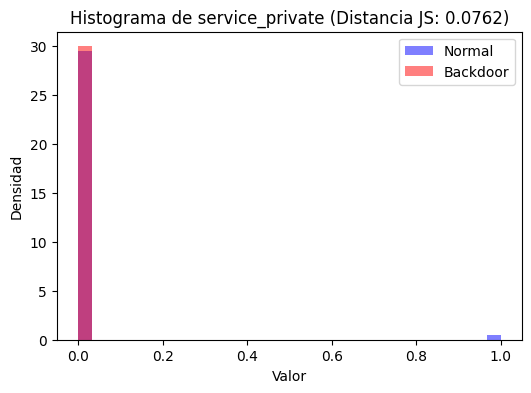

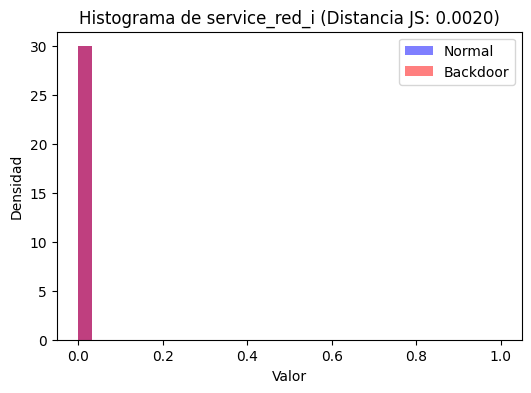

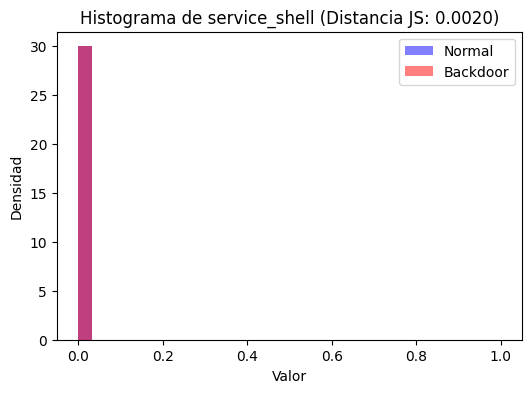

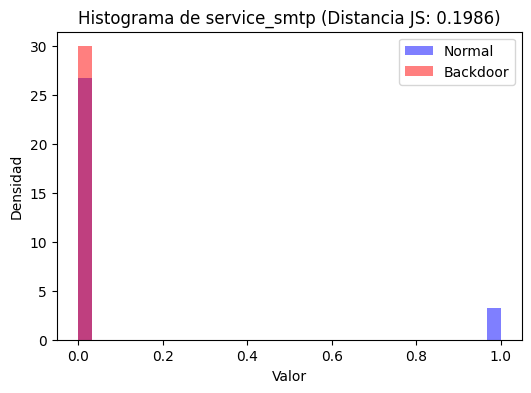

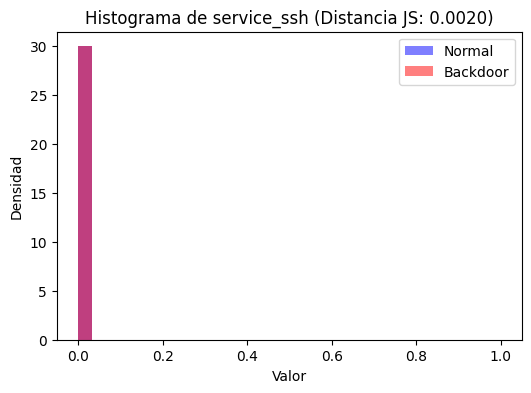

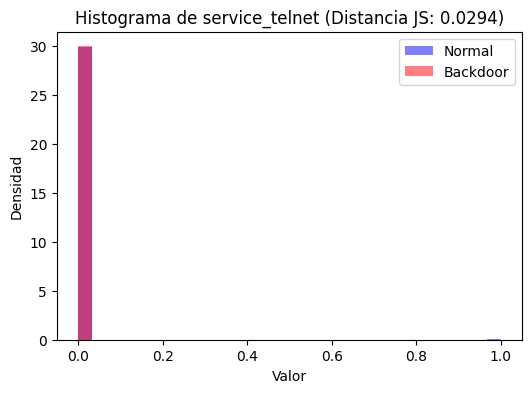

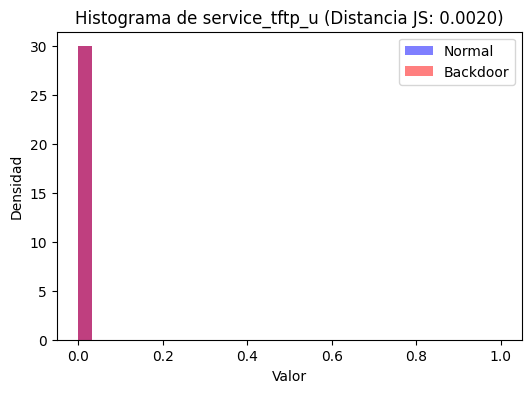

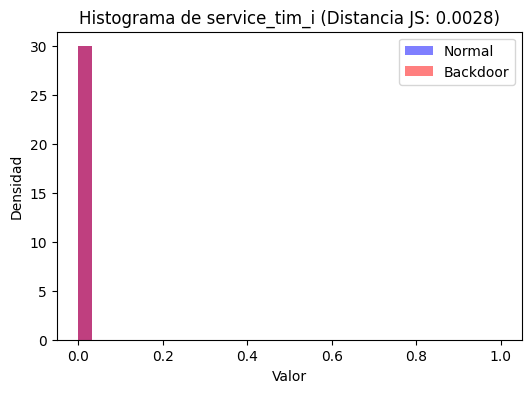

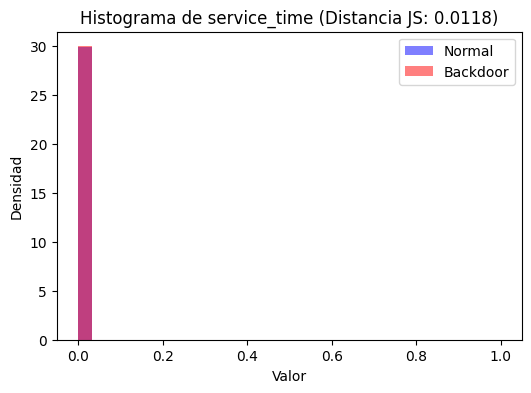

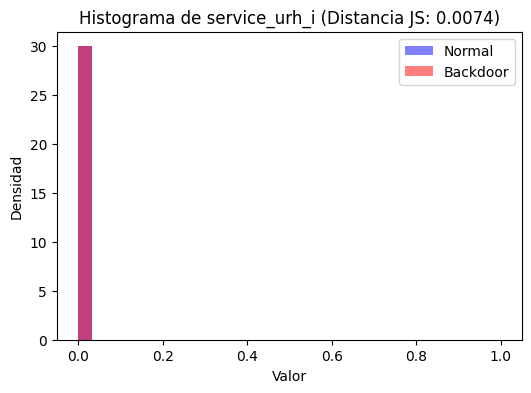

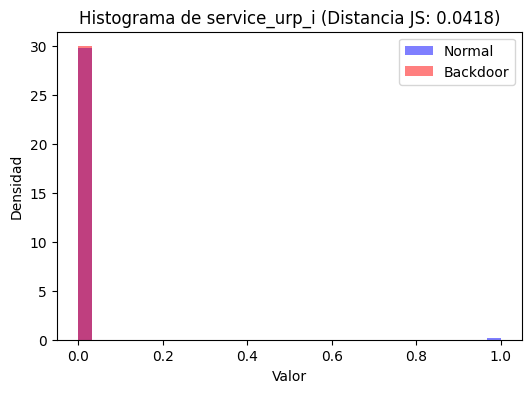

,Feature,DistanciaJS
6,hot,0.813179
37,dst_host_srv_rerror_rate,0.466678
36,dst_host_rerror_rate,0.459732
24,srv_rerror_rate,0.373477
60,service_http,0.346864
...,...,...
70,service_tftp_u,0.001986
38,flag_OTH,0.001986
4,wrong_fragment,0.000000
16,num_outbound_cmds,0.000000


In [17]:
generate_feature_histogram_and_calculate_jensen_shannon(df_normal_without_outcome, df_attacks_without_outcome,
                                                        attack_without_outcomes_column_names)

# Parte 2 Implementación de la clasificación multi-clase con árboles de decisión

## Implementación final de las clases NodeCart y Cart

In [18]:
class NodeCart:
    def __init__(self, num_classes=2, ref_cart=None, current_depth=0):
        """
        Create the node attributes
        param num_classes: K number of classes to classify
        param ref_cart: reference to the tree containing the node
        param current_depth: current depth of the node in the tree
        """
        self.ref_cart = ref_cart
        self.threshold_value = 0
        self.feature_num = 0
        self.node_right = None
        self.node_left = None
        self.data_torch_partition = None
        self.gini = 0
        self.dominant_class = None
        self.accuracy_dominant_class = None
        self.num_classes = num_classes
        self.current_depth = current_depth

    def to_xml(self, current_str=""):
        """
        Recursive function to write the node content to an xml formatted string
        param current_str : the xml content so far in the whole tree
        return the string with the node content
        """
        str_node = "<node><thresh>" + str(self.threshold_value) + "</thresh>" + "<feature>" + str(
            self.feature_num) + "</feature><depth>" + str(self.current_depth) + "</depth>"
        str_node += "<gini>" + str(self.gini) + "</gini>"
        if self.node_right is not None:
            str_left = self.node_right.to_xml(current_str)
            str_node += str_left
        if self.node_left is not None:
            str_right = self.node_left.to_xml(current_str)
            str_node += str_right

        if self.is_leaf():
            str_node += "<dominant_class>" + str(self.dominant_class) + "</dominant_class><acc_dominant_class>" + str(
                self.accuracy_dominant_class) + "</acc_dominant_class>"
        str_node += "</node>"
        return str_node

    def is_leaf(self):
        """
        Checks whether the node is a leaf
        """
        return self.node_left is None and self.node_right is None

    def create_with_children(self, data_torch, current_depth, min_gini=0.000001):
        """
        Creates a node by selecting the best feature and threshold, and if needed, creating its children
        param data_torch: dataset with the current partition to deal with in the node
        param current_depth: depth counter for the node
        param min_gini: hyperparameter selected by the user defining the minimum tolerated Gini coefficient for a  node
        return the list of selected features so far
        """
        # return list_selected_features

    def select_best_feature_and_thresh(self, data_torch, num_classes=2):
        """
        Selects the best feature and threshold that minimizes the Gini coefficient
        param data_torch: dataset partition to analyze
        param num_classes: number of K classes to discriminate from
        return min_thresh, min_feature, min_gini found for the dataset partition when
        selecting the found feature and threshold
        """
        # return min_thresh, min_feature, min_gini found

    def calculate_gini(self, data_partition_torch, num_classes=2):
        """
        Calculates the Gini coefficient for a given partition with the given number of classes
        param data_partition_torch: current dataset partition as a tensor
        param num_classes: K number of classes to discriminate from
        returns the calculated Gini coefficient
        """
        if data_partition_torch.numel() == 0:
            return 0.0

        class_counts = torch.bincount(data_partition_torch, minlength=num_classes).float()
        proportions = class_counts / class_counts.sum()
        gini_score = 1.0 - torch.sum(proportions ** 2)
        return gini_score.item()

    def weighted_gini(self, left_side, right_side, num_classes=2):
        n = left_side.numel() + right_side.numel()
        if n == 0:
            return 0.0
        gini_left = self.calculate_gini(left_side, num_classes)
        gini_right = self.calculate_gini(right_side, num_classes)
        return (left_side.numel() / n) * gini_left + (right_side.numel() / n) * gini_right

    def evaluate_node(self, input_torch):
        """
        Evaluates an input observation within the node.
        If is not a leaf node, send it to the corresponding node
        return predicted label
        """
        feature_val_input = input_torch[self.feature_num]
        if self.is_leaf():
            return self.dominant_class
        else:
            if feature_val_input < self.threshold_value:
                return self.node_left.evaluate_node(input_torch)
            else:
                return self.node_right.evaluate_node(input_torch)


class CART:
    def __init__(self, dataset_torch, max_cart_depth, min_observations=2):
        """
        CART has only one root node
        """
        #min observations per node
        self.min_observations = min_observations
        self.root = NodeCart(num_classes=2, ref_cart=self, current_depth=0)
        self.max_cart_depth = max_cart_depth
        self.list_selected_features = []

    def get_root(self):
        """
        Gets tree root
        """
        return self.root

    def get_min_observations(self):
        """
        return min observations per node
        """
        return self.min_observations

    def get_max_depth(self):
        """
        Gets the selected max depth of the tree
        """
        return self.max_cart_depth

    def build_cart(self, data_torch):
        """
        Build CART from root
        """
        self.list_selected_features = self.root.create_with_children(data_torch, current_depth=0)

    def to_xml(self, xml_file_name):
        """
        write Xml file with tree content
        """
        str_nodes = self.root.to_xml()
        file = open(xml_file_name, "w+")
        file.write(str_nodes)
        file.close()
        return str_nodes

    def evaluate_input(self, input_torch):
        """
        Evaluate a specific input in the tree and get the predicted class
        """
        return self.root.evaluate_node(input_torch)

## A) Implementación de calculo de Gini

### 1a Pruebas unitarias para el calculo de Gini

In [19]:
node = NodeCart(num_classes=2)
ones_tensor = torch.tensor([1, 1, 1, 1])
gini = node.calculate_gini(ones_tensor, num_classes=2)
assert gini == 0.0, f"Expected 0.0, got {gini}"
print("Test 1 Gini ✅")

variable_tensor = torch.tensor([0, 1, 2, 3])
gini = node.calculate_gini(variable_tensor, num_classes=4)
assert gini == 0.75, f"Expected 0.75, got {gini}"
print("Test 2 Gini ✅")

Test 1 Gini ✅
Test 2 Gini ✅


## B) Implemente los metodos select_best_feature_and_thresh(data_torch,num_classes = 2) y create_with_children, de la clase Node_CART.

### Implementación de select_best_feature_and_thresh